In [8]:
import warnings
import yaml
import pandas as pd
from sqlalchemy import create_engine
from types import SimpleNamespace as sn

warnings.filterwarnings('ignore')
with open('config.yaml') as f:
    config = sn(**yaml.load(f, Loader=yaml.FullLoader))
config_db, path = sn(**config.db), config.path

cnx = create_engine(
    f'postgresql://{config_db.user}:{config_db.psswd}@{config_db.host}/{config_db.dbname}')
cnx.connect()
maps, uvs = pd.read_sql_table('maps', cnx), pd.read_sql_table('catalogue', cnx)

OperationalError: (psycopg2.OperationalError) connection to server at "odin.asc.rssi.ru" (193.232.12.56), port 5432 failed: FATAL:  no pg_hba.conf entry for host "93.175.6.88", user "zagorulia", database "astrogeo", SSL encryption
connection to server at "odin.asc.rssi.ru" (193.232.12.56), port 5432 failed: FATAL:  no pg_hba.conf entry for host "93.175.6.88", user "zagorulia", database "astrogeo", no encryption

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

class Filter(object):
	def __init__(self, df: pd.DataFrame):
		self.maps = df
		self.filter_df()
		self.kmeans, self.X = None, None
	
	def draw_sn_dist(self) -> None:
		signal_noise = [sig/nl for sig, nl in zip(self.maps.map_max, self.maps.noise_level)]
		fig = plt.figure(figsize=(10, 8))
		ax = fig.add_subplot(1, 1, 1)
		ax.set_title('Signal/noise distribution')
		sns.histplot(signal_noise)
		ax.set_xlabel('Signal-noise ratio')
		ax.set_ylabel('Number')
		plt.savefig('signal_noise_dist.png', dpi=500)
		plt.close(fig)

	def weird_maps(self) -> set:
		df = self.maps
		weird_maps = []
		for c_x, x, c_y, y, a, file in zip(df.mapc_x, df.map_max_x, df.mapc_y, df.map_max_y, df.obs_author, df.file_name):
			if (abs(c_x - x) > 3 or abs(c_y - y) > 3) and a != 'Alan Marscher':
				weird_maps.append(file)
		return set(weird_maps)

	def maps_w_bad_signal_noise(self, ratio: int) -> dict:
		signal_noise = {file: sig/nl 
				 	for file, sig, nl in zip(self.maps.file_name, self.maps.map_max, self.maps.noise_level)
					if sig/nl <= ratio}
		return signal_noise
	
	def filter_df(self) -> None:
		wm = self.weird_maps()
		signal_noise = self.maps_w_bad_signal_noise(10)
		bad_maps = wm.union(signal_noise)

		for x in self.maps.index:
			b_maj, b_min = self.maps.loc[x, 'b_maj'], self.maps.loc[x, 'b_min']
			file_name = self.maps.loc[x, 'file_name']
			if b_maj == -1 or b_min == -1 or file_name in bad_maps:
				self.maps.drop(x, inplace=True)
	
	def _beam_clustering(self, n: int) -> None:
		X = self.maps[['b_maj', 'b_min', 'b_pa']].to_numpy()
		self.kmeans = KMeans(n_clusters=n, random_state=0, n_init='auto').fit(X)
		labels = np.array([self.kmeans.labels_])
		self.X = np.concatenate((X, labels.T), axis=1)

	def beam_cluster_means(self) -> pd.DataFrame:
		if self.X is None:
			raise ValueError
		
		data = self.X
		means = {}
		for ind, label in enumerate(data[:, 3]):
			label = int(label)
			if label not in means:
				means[label] = [data[ind, 0], data[ind, 1], data[ind, 2], 1]
			else:
				for i in range(3):
					means[label][i] += data[ind, i]
				means[label][3] += 1
		
		for label in means:
			count = means[label][3]
			for i in range(3):
				means[label][i] /= count
		
		df = pd.DataFrame(means).T
		df = df.rename(columns={0: 'b_maj', 1: 'b_min', 2: 'b_pa', 3: 'amount'})
		df.index.name = 'Cluster'
		df.amount = df.amount.astype(int)
		for col in df.columns:
			if col != 'amount':
				df[col] = df[col].apply(lambda x: np.format_float_scientific(x, precision=2))
		df.sort_index()
		return df
		
	def draw_beam_clustering(self, n: int) -> None:
		if self.kmeans is None or self.X is None:
			self._beam_clustering(n)
			X = self.X

		fig = plt.figure()
		ax = fig.add_subplot(projection='3d')
		ax.scatter(X[:, 0] * 1e6, X[:, 1] * 1e6, X[:, 2], c=self.kmeans.labels_.astype(float))
		ax.set_xlabel(r'b_maj, $10^6$ arcsec')
		ax.set_ylabel(r'b_min, $10^6$ arcsec')
		ax.set_zlabel('b_pa, degrees')
		plt.savefig(f'beam_3d.png', dpi=500)
		plt.close(fig)
	
	def draw_b_min_dist(self) -> None:
		X = self.maps[['b_min']].to_numpy()
		fig = plt.figure(figsize=(10, 8))
		ax = fig.add_subplot(1, 1, 1)
		ax.set_title('Beam MIN distribution')
		sns.histplot(X * 1e6)
		ax.set_xlabel('B_MIN')
		ax.set_ylabel('Number')
		ax.set_xlim(0, 10)
		plt.savefig('beam_min_dist.png', dpi=500)
		plt.close(fig)
	
	def draw_b_maj_dist(self) -> None:
		X = self.maps[['b_maj']].to_numpy()
		fig = plt.figure(figsize=(10, 8))
		ax = fig.add_subplot(1, 1, 1)
		ax.set_title('Beam MAJ distribution')
		sns.histplot(X * 1e6)
		ax.set_xlabel('B_MAJ')
		ax.set_ylabel('Number')
		ax.set_xlim(0, 10)
		plt.savefig('beam_maj_dist.png', dpi=500)
		plt.close(fig)
	
	def draw_b_pa_dist(self) -> None:
		X = self.maps[['b_pa']].to_numpy()
		fig = plt.figure(figsize=(10, 8))
		ax = fig.add_subplot(1, 1, 1)
		ax.set_title('Beam PA distribution')
		sns.histplot(X)
		ax.set_xlabel('B_PA')
		ax.set_ylabel('Number')
		plt.savefig('beam_pa_dist.png', dpi=500)
		plt.close(fig)

In [ ]:
wm = Filter(maps)
wm._beam_clustering(10)
wm.beam_cluster_means()

In [ ]:
from sklearn.preprocessing import normalize

a = np.array(['A', 'B', 'A', 'C'])
np.unique(a, return_inverse=True)[1]

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

fig.savefig("foo.pdf", bbox_inches='tight')

In [9]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime

with PdfPages('multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    plt.rc('text', usetex=True)
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.savefig()
    plt.close()

    plt.rc('text', usetex=False)
    fig = plt.figure(figsize=(4, 5))
    plt.plot(x, x*x, 'ko')
    plt.title('Page Three')
    pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
    plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = u'Jouni K. Sepp\xe4nen'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x1302d4670> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 300x300 with 1 Axes>

In [ ]:
data = [[1, 2, 3, 4, 6] * 6]
with PdfPages('multipage_pdf.pdf') as pdf:
    fig, axes = plt.subplots(3, 2)
    for ax, d in zip(axes, data[0: 6]):
        fig.plot(d, [3, 1, 4, 1, 5, 9, 2], 'r-o')
        ax.set_title('Page >')
    pdf.savefig()
    plt.close(fig)

<class 'matplotlib.axes._axes.Axes'>


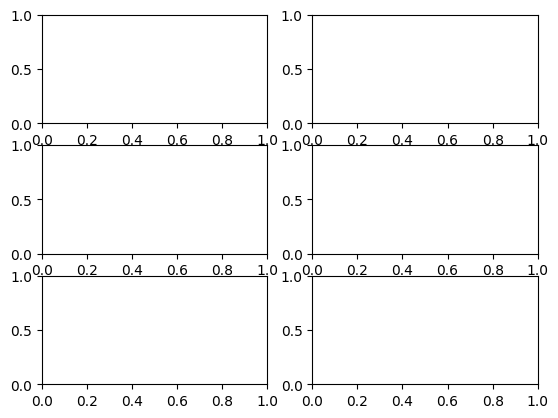

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2)
print(type(axes[0][0]))